In [26]:
from random import random
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

Fetching 3-year stock history.

<AxesSubplot:xlabel='Date'>

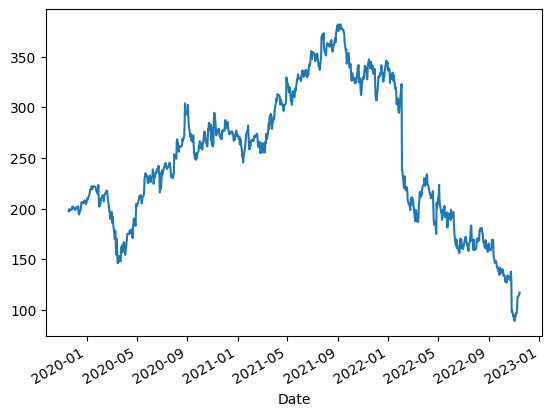

In [27]:
meta = yf.Ticker('META')
hist = meta.history(period='3y')
close = hist['Close']
close.plot()

Calculate the percent changes per day in the closing price over this period to find the daily returns.

In [28]:
daily_returns = close.pct_change().dropna()
daily_returns

Date
2019-11-19    0.009727
2019-11-20   -0.009081
2019-11-21    0.002126
2019-11-22    0.004497
2019-11-25    0.004879
                ...   
2022-11-09    0.051830
2022-11-10    0.102493
2022-11-11    0.010280
2022-11-14    0.010618
2022-11-15    0.025039
Name: Close, Length: 754, dtype: float64

Calculate the mean and standard deviation of the daily returns. These will be used to construct a Gaussian probability distribution that is randomly sampled for the random walk.

[https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk)

In [29]:
mean = np.mean(daily_returns)
std = np.std(daily_returns)
mean, std

(-0.00021870939507939385, 0.030226693187653288)

The simulation. The magic happens with SciPy's ``norm.ppf()``. It creates a Gaussian probability distrubution with the given mean and standard deviation of the daily returns. It also takes in a ``q`` value which is the probability (a number between 0 and 1, inclusive) and returns the corresponding x-value. For it to be a random walk, our ``q`` value will be randomly generated. We will also calculate the holding period return (HPR) for each simulation, which is the percent change between our closing prices on the last simulated day and the day right before the simulation started.

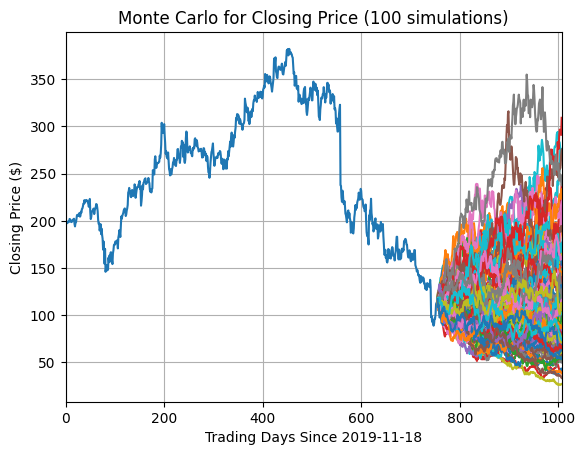

In [48]:
hist_days = [i for i in range(1, len(close) + 1)] # days in history
sim_days = 252 # 1 year
simulations = 100
hpr = [] # will contain HPRs

# plotting history before simulating
plt.plot(hist_days, close.tolist())
plt.title('Monte Carlo for Closing Price (' +
            str(simulations) + ' simulations)')
plt.xlabel('Trading Days Since ' + str(close.index[0].date()))
plt.ylabel('Closing Price ($)')
plt.xlim([0, len(hist_days) + sim_days])
plt.grid()

# running the simulation
for i in range(simulations):
    future_days = [hist_days[-1]]
    sim_close = [close[-1]]
    
    for j in range(sim_days):
        future_days.append(future_days[-1] + 1)
        q = random()
        observation = sim_close[-1]
        step_size = norm.ppf(q, mean, std) * observation
        expected_value = observation + step_size
        sim_close.append(expected_value)

    # calculate HPR for this simulation
    last_close = close[-1]
    last_sim_close = sim_close[-1]
    current_hpr = (last_sim_close - last_close) / last_close
    hpr.append(current_hpr)

    # plotting current simulation
    plt.plot(future_days, sim_close)

The holding period returns we calculated for each simulation can be displayed as a histogram. This will give us an idea about whether we observe more negative returns, more positive returns, etc.

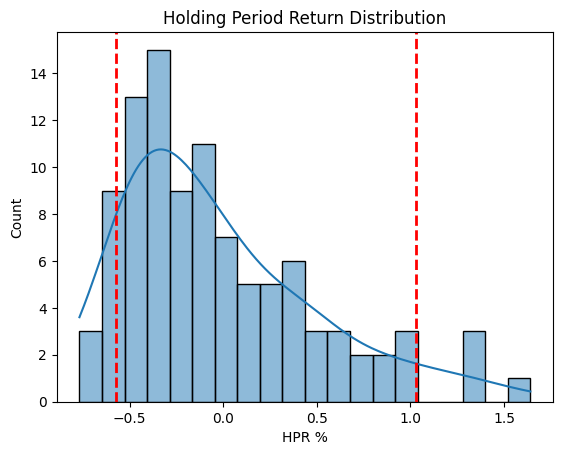

In [49]:
sns.histplot(hpr, kde=True, bins=20)
plt.title('Holding Period Return Distribution')
plt.xlabel('HPR %')
plt.axvline(np.percentile(hpr, 5), color='r', linestyle='dashed',
            linewidth=2)
plt.axvline(np.percentile(hpr, 95), color='r', linestyle='dashed',
            linewidth=2)
plt.show()

We can observe that a majority of our simulated holding period returns are negative.